# Formula 1 Cars image classification 

In [8]:
import os 
import pandas
import seaborn
import tensorflow as tf
import numpy
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Concatenate, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from shutil import copyfile
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import shutil

In [2]:
data_dir = "/Users/danielbustillo/Documents/Formula One Cars/"

In [3]:

# load image as pixel array
data = image.imread(f'{data_dir}/Ferrari F1 car/00000022.jpg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
plt.imshow(data)
plt.show()

NameError: name 'image' is not defined

## Data cleaning

In [42]:
def find_files_with_different_extension(directory, target_extension):
    different_extension_files = []

    for foldername, subfolders, filenames in os.walk(directory):
        for filename in filenames:
            if filename == '.DS_Store':
                file_path = os.path.join(foldername, filename)
                os.remove(file_path)
                continue
            
            file_extension = os.path.splitext(filename)[1]
            if file_extension.lower() != target_extension.lower(): #what does this do?
                different_extension_files.append(os.path.join(foldername, filename))

    return different_extension_files


target_extension = '.jpg'

different_extension_files = find_files_with_different_extension(data_dir, target_extension)


if different_extension_files:
    print("Files with different extensions:")
    for file_path in different_extension_files:
        new_file_path = os.path.splitext(file_path)[0] + target_extension
        shutil.move(file_path, new_file_path)
        
    #do nothing

In [43]:
for foldername, subfolders, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename == '.DS_Store':
            file_path = os.path.join(foldername, filename)
            os.remove(file_path)


## Splitting data set into test and train data


In [45]:
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/test')

In [46]:
for folder in os.listdir(data_dir):
    files=os.listdir(os.path.join(data_dir,folder))
    images=[]
    for f in files:
        try:
            img=Image.open(os.path.join(data_dir,folder,f))
            img=tf.io.read_file(os.path.join(data_dir,folder,f))
            img=tf.image.decode_image(img)
            if img.ndim == 3:
                images.append(f)
        except:
            pass
                      
    random.shuffle(images)
    count=len(images)
    split=int(0.7*count)
    os.mkdir(os.path.join('./data/train',folder))
    os.mkdir(os.path.join('./data/test',folder))

    for c in range(split):
        source_file=os.path.join(data_dir,folder,images[c])
        distination=os.path.join('./data/train',folder,images[c])
        copyfile(source_file,distination)
    for c in range(split,count):
        source_file=os.path.join(data_dir,folder,images[c])
        distination=os.path.join('./data/test',folder,images[c])
        copyfile(source_file,distination)   

2024-01-17 16:57:51.183469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-01-17 16:58:15.640725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-01-17 16:58:17.323983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-01-17 16:58:17.598381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [47]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,   # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift the width of the image by up to 20%
    height_shift_range=0.2,  # Randomly shift the height of the image by up to 20%
    shear_range=0.2,   # Shear the image by up to 20%
    zoom_range=0.2,    # Zoom in by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in empty pixels using the nearest available pixel
)
'''


In [48]:
'''batch_size = 32
image_size = (224, 224)  # You can adjust the image size as needed

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=True  # Shuffle the order of images
)
'''


Found 2486 images belonging to 8 classes.


In [4]:
IMAGE_SIZE=(224,224)
train_dir='./data/train'
test_dir='./data/test'

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

class_names=train_data.class_names

# prefetching the datasets for faster training
train_data=train_data.prefetch(tf.data.AUTOTUNE)
test_data=test_data.prefetch(tf.data.AUTOTUNE)

Found 1572 files belonging to 8 classes.
Found 678 files belonging to 8 classes.


In [5]:
def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),6)
    plt.figure(figsize=(20,5))
    for i in range(6):
        
        plt.subplot(1,6,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        img=tf.image.resize(img,(224,244))
        plt.imshow(img/255.0)
        plt.title(f'{target_class}\n{img.shape}',size=20)
        plt.xticks([]);
        plt.yticks([])
        plt.tight_layout()
    plt.show()


/var/folders/c1/t5fkfr595z347dnt3qpgv4qm0000gn/T/ipykernel_26315/2408108861.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


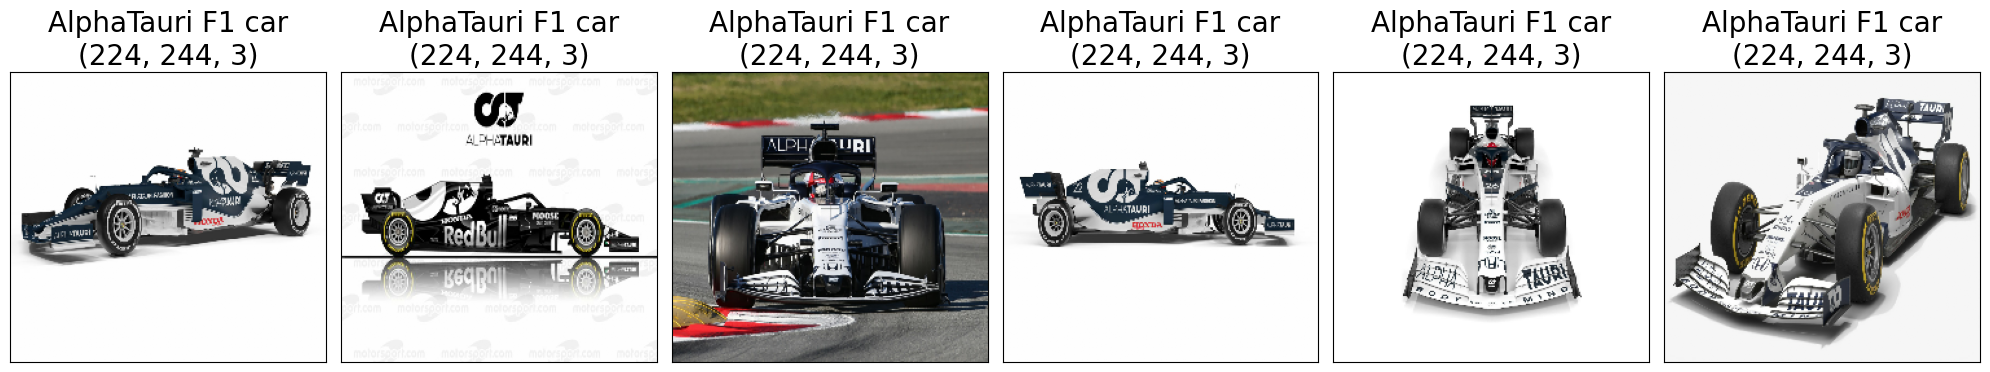

In [6]:
plot_random_image(train_dir)

In [13]:
# Train the model 


num_classes = 8 # we are classifying each brand of car

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax') )


In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
epochs = 10  # Adjust the number of epochs as needed
history = model.fit(train_data, epochs=epochs, validation_data=test_data)


In [66]:
test_loss,test_acc=model.evaluate(test_data)

22/22 [==============================] - 6s 254ms/step - loss: 3.8140 - accuracy: 0.2035


In [17]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);

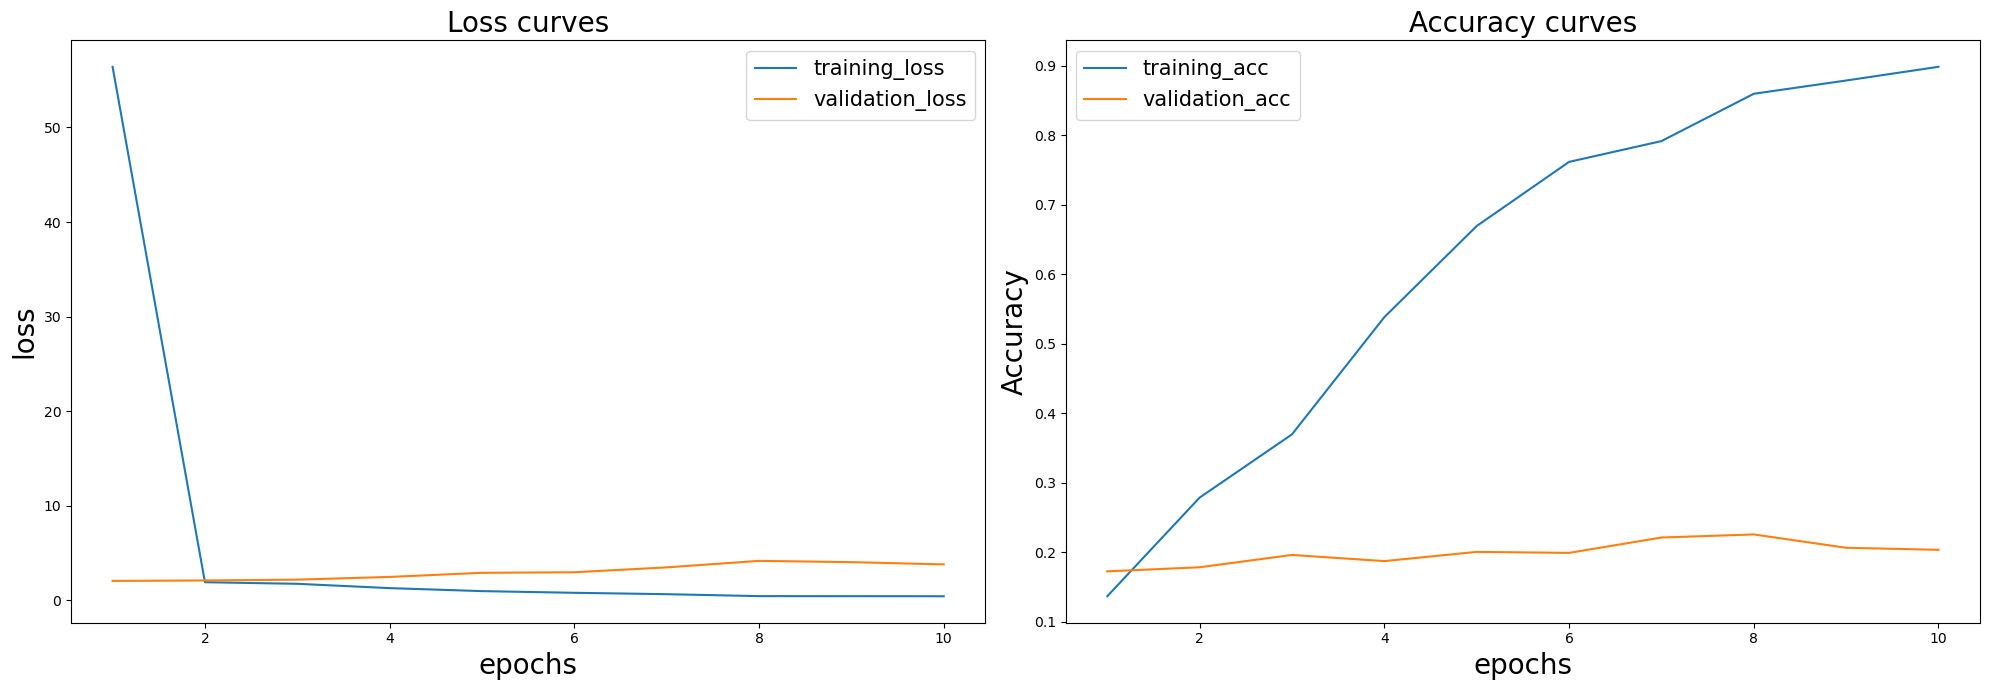

In [68]:
plot_loss_curves(history)

## Trying out ResNetTx model architecture


In [11]:


def grouped_convolution_block(input_tensor, filters, cardinality, kernel_size=(3, 3), strides=(1, 1)):
    grouped_channels = filters // cardinality

    groups = []
    for group_index in range(cardinality):
        x = Conv2D(grouped_channels, kernel_size, strides=strides, padding='same')(input_tensor)
        groups.append(x)

    return Concatenate()(groups)

def residual_block(input_tensor, filters, cardinality=32, kernel_size=(3, 3), strides=(1, 1)):
    shortcut = input_tensor

    x = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = grouped_convolution_block(x, filters, cardinality, kernel_size, strides)

    x = Conv2D(filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def build_resnext(input_shape=(224, 224, 3), num_classes=8, cardinality=32, blocks=[3, 4, 6, 3]):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, 64, cardinality, strides=(2, 2))

    for block in blocks:
        x = residual_block(x, 128, cardinality)
        for _ in range(block - 1):
            x = residual_block(x, 128, cardinality)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model

# Example: Create a ResNeXt model
resnext_model = build_resnext()
resnext_model.summary()


ValueError: Inputs have incompatible shapes. Received shapes (28, 28, 64) and (56, 56, 64)

In [14]:
# Create a ResNet50 model with pre-trained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False

    # Add a custom output layer
    x = resnet_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

# Define the new model
resnet_model = Model(inputs=resnet_model.input, outputs=output_layer)





In [15]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model

epochs = 10  # Adjust the number of epochs as needed
history = resnet_model.fit(train_data, epochs=epochs, validation_data=test_data)

Epoch 1/10


2024-02-02 12:28:48.553035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1572]
	 [[{{node Placeholder/_0}}]]
2024-02-02 12:28:48.553387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1572]
	 [[{{node Placeholder/_4}}]]
2024-02-02 12:28:49.736437: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-02 12:28:50.944199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:28:51.167036: W tensorflow/core/lib/png/png_io.cc:88] PNG warni

 2/50 [>.............................] - ETA: 49s - loss: 4.8728 - accuracy: 0.1406 

2024-02-02 12:28:53.901135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - ETA: 0s - loss: 2.2651 - accuracy: 0.3976

2024-02-02 12:29:35.997808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [678]
	 [[{{node Placeholder/_4}}]]
2024-02-02 12:29:35.997997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [678]
	 [[{{node Placeholder/_4}}]]


50/50 [==============================] - 68s 1s/step - loss: 2.2651 - accuracy: 0.3976 - val_loss: 0.9957 - val_accuracy: 0.6888
Epoch 2/10


2024-02-02 12:29:57.169102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:29:57.382935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 46s - loss: 0.9951 - accuracy: 0.6406 

2024-02-02 12:29:59.903589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 68s 1s/step - loss: 1.0084 - accuracy: 0.6419 - val_loss: 0.8654 - val_accuracy: 0.7242
Epoch 3/10


2024-02-02 12:31:05.295271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:31:05.507163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 48s - loss: 0.6998 - accuracy: 0.7656 

2024-02-02 12:31:08.207956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 67s 1s/step - loss: 0.8444 - accuracy: 0.7144 - val_loss: 0.7521 - val_accuracy: 0.7345
Epoch 4/10


2024-02-02 12:32:12.200322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:32:12.418573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 45s - loss: 0.6801 - accuracy: 0.7031 

2024-02-02 12:32:15.071908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 67s 1s/step - loss: 0.6456 - accuracy: 0.7780 - val_loss: 0.7016 - val_accuracy: 0.7699
Epoch 5/10


2024-02-02 12:33:19.836150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:33:20.071509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 47s - loss: 0.5770 - accuracy: 0.7812 

2024-02-02 12:33:22.764057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 65s 1s/step - loss: 0.6062 - accuracy: 0.7958 - val_loss: 0.6591 - val_accuracy: 0.7920
Epoch 6/10


2024-02-02 12:34:24.772746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:34:24.985215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 45s - loss: 0.4897 - accuracy: 0.8594 

2024-02-02 12:34:27.502960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 64s 1s/step - loss: 0.4864 - accuracy: 0.8499 - val_loss: 0.6579 - val_accuracy: 0.7920
Epoch 7/10


2024-02-02 12:35:28.777698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:35:28.989911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 45s - loss: 0.4083 - accuracy: 0.8750 

2024-02-02 12:35:31.534599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 64s 1s/step - loss: 0.4340 - accuracy: 0.8473 - val_loss: 0.6599 - val_accuracy: 0.7817
Epoch 8/10


2024-02-02 12:36:33.063789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:36:33.275162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 42s - loss: 0.3393 - accuracy: 0.8750 

2024-02-02 12:36:35.986585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 64s 1s/step - loss: 0.3565 - accuracy: 0.8798 - val_loss: 0.7050 - val_accuracy: 0.7817
Epoch 9/10


2024-02-02 12:37:36.921975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:37:37.133484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 46s - loss: 0.3023 - accuracy: 0.9219 

2024-02-02 12:37:39.694054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 64s 1s/step - loss: 0.3805 - accuracy: 0.8772 - val_loss: 0.6597 - val_accuracy: 0.7847
Epoch 10/10


2024-02-02 12:38:40.709010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-02 12:38:40.919759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/50 [>.............................] - ETA: 44s - loss: 0.3583 - accuracy: 0.8906 

2024-02-02 12:38:43.431714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/50 [==============================] - 64s 1s/step - loss: 0.3418 - accuracy: 0.8849 - val_loss: 0.6790 - val_accuracy: 0.7729


In [16]:
#Evaluate the model
test_loss, test_acc = resnet_model.evaluate(test_data)

22/22 [==============================] - 20s 876ms/step - loss: 0.6790 - accuracy: 0.7729


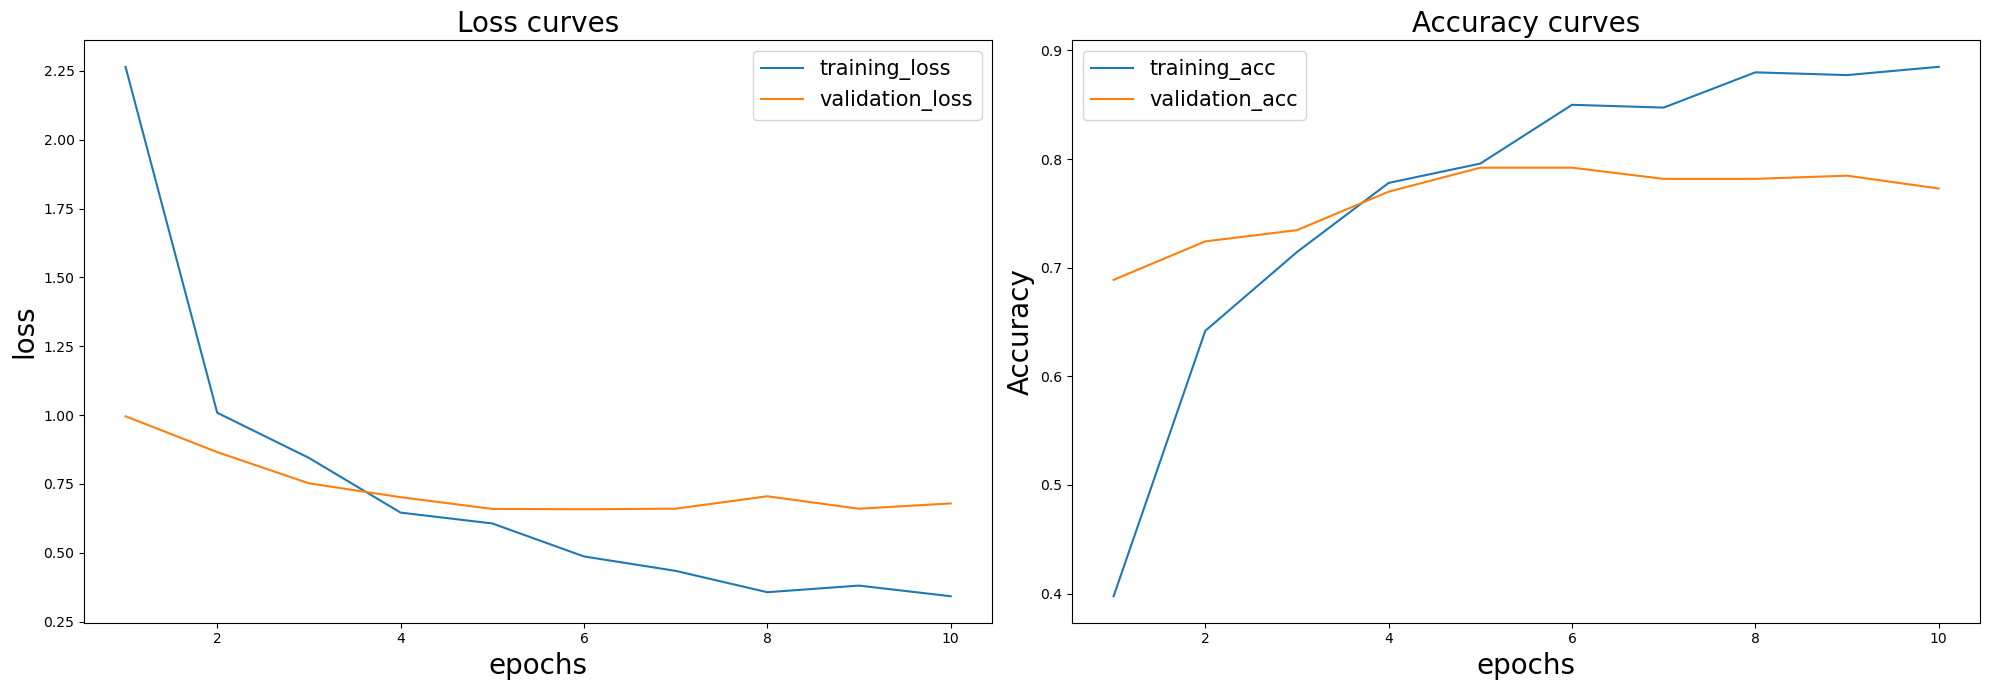

In [18]:
plot_loss_curves(history)